In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Storytelling
L'obbiettivo di questa analisi è mostrare/vedere l'impatto dei cartellini rossi e gialli sul risultato delle partite e sulla performance delle squadre

In [215]:
# Load data from CSV files
games = pd.read_csv('./data/games.csv')
game_events = pd.read_csv('./data/game_events.csv')
players = pd.read_csv('./data/players.csv')
competitions = pd.read_csv('./data/competitions.csv')

games_df = pd.read_csv('./data/transformed_games2.csvcsv')

card_events = game_events[game_events['type'] == 'Cards']
goal_events = game_events[game_events['type'] == 'Goals']

game_events

FileNotFoundError: [Errno 2] No such file or directory: './data/transformed_games2.csvcsv'

In [214]:
# Gestire i valori nulli nella colonna 'description'
game_events['description'] = game_events['description'].fillna('')

# Filtrare i cartellini gialli e rossi
num_yellow = game_events[(game_events['type'] == 'Cards') & (game_events['description'].str.contains('yellow', case=False))]
num_red = game_events[(game_events['type'] == 'Cards') & (game_events['description'].str.contains('red', case=False) | game_events['description'].str.contains('second', case=False))]
num_tot = game_events[game_events['type'] == 'Cards']

print(
    f' Numero cartellini rossi: {len(num_red)}\n',
    f'Numero cartellini gialli: {len(num_yellow)}\n',
    f'Numero cartellini totali: {len(num_tot)}'
)


 Numero cartellini rossi: 3585
 Numero cartellini gialli: 60693
 Numero cartellini totali: 62473


Vediamo che la stragrande maggioranza dei cartellini sono cartellini gialli <br>
perciò sostiuiremo i valori vuoti con cartellini gialli

## Creazione tabella 
per comodità creiamo un nuovo file che contenga le informazioni che ci interessano per fare le nostre considerazioni:
il numero di cartellini ricevuti, il numero di goal fatti e ricevuti e il risultato della partita

In [ ]:

not_nan = game_events.copy()
not_nan = not_nan.fillna('yellow') # riempiamo con il valore più comune

# Funzione per contare i cartellini in base al tipo specificato
def count_cards(game_id, club_id, card_type=None):
    events = not_nan[(not_nan['game_id'] == game_id) & (not_nan['club_id'] == club_id)]
    if card_type is None:
        return len(events[events['type'] == 'Cards'])
    elif card_type == 'yellow':
        return len(events[
            (events['type'] == 'Cards') &
            (events['description'].str.contains('yellow', case=False)) &
            (~events['description'].str.contains('second', case=False))
        ])
    elif card_type == 'red':
        return len(events[
            (events['type'] == 'Cards') &
            (events['description'].str.contains('red', case=False) | 
             events['description'].str.contains('second', case=False))
        ])

# Creiamo il nuovo dataframe che contenga i dati sopra citati
transformed_games = []

# Transform the games data
for index, row in games.iterrows():
    home_row = {
        'game_id': row['game_id'],
        'club_id': row['home_club_id'],
        'date': row['date'],
        'competition_id': row['competition_id'],
        'season': row['season'],
        'round': row['round'],
        'goals_received': row['away_club_goals'],
        'goals_made': row['home_club_goals'],
        'cards_received': count_cards(row['game_id'], row['home_club_id']),
        'cards_received_yellow': count_cards(row['game_id'], row['home_club_id'], 'yellow'),
        'cards_received_red': count_cards(row['game_id'], row['home_club_id'], 'red'),
        'is_win': 1 if row['home_club_goals'] > row['away_club_goals'] else (
            0 if row['home_club_goals'] < row['away_club_goals'] else -1)
    }

    away_row = {
        'game_id': row['game_id'],
        'club_id': row['away_club_id'],
        'date': row['date'],
        'competition_id': row['competition_id'],
        'season': row['season'],
        'round': row['round'],
        'goals_received': row['home_club_goals'],
        'goals_made': row['away_club_goals'],
        'cards_received': count_cards(row['game_id'], row['away_club_id']),
        'cards_received_yellow': count_cards(row['game_id'], row['away_club_id'], 'yellow'),
        'cards_received_red': count_cards(row['game_id'], row['away_club_id'], 'red'),
        'is_win': 1 if row['away_club_goals'] > row['home_club_goals'] else (
            0 if row['away_club_goals'] < row['home_club_goals'] else -1)
    }

    transformed_games.append(home_row)
    transformed_games.append(away_row)

# Convertiamo la struttura in un dataframe di panda e salviamolo in un nuovo csv
transformed_games_df = pd.DataFrame(transformed_games)

# Salviamo il DataFrame nel CSV
transformed_games_df.to_csv('./data/transformed_games.csv', index=False)


## Data Cleaning:

### 1) Distribuzione dei valori di cards_received:

In [216]:
# Intanto vediamo qual'è la distribuzione del numero di cartellini 
print(
    f' Massimo e minimo tra i valori di cards_received: \n {games_df['cards_received'].min()} {games_df['cards_received'].max()}')

# Vediamo che il massimo è 11 cartellini, che essendo veramente tanti sarebbe meglio controllare il numero di record per ciascun valore 
(games_df['cards_received']).value_counts().sort_index()

# Vediamo che il numero di record con un valore di numero cartellini compreso tra 5 e 11 è davvero basso. Ciò potrebbe portare a risultati fallati. 
# Potrebbe essere una buona idea raggruppare i valori maggiori di 4 in un unica etichetta '5+'
games_df['cards_received'] = games_df['cards_received'].apply(lambda x: 5 if x >= 5 else x)
(games_df['cards_received']).value_counts().sort_index()



 Massimo e minimo tra i valori di cards_received: 
 0 11


cards_received
0    105375
1      6872
2      7440
3      5522
4      3070
5      2153
Name: count, dtype: int64

# Analisi:

 ## differenza di probabilità di sconfitta in base al numero di cartellini ricevuti <br>
 Per poter visualizzare questa eventualità utilizzeremo una heatmap per mettere in relazione la probabilità di sconfitta con il numero di cartellini ricevuti

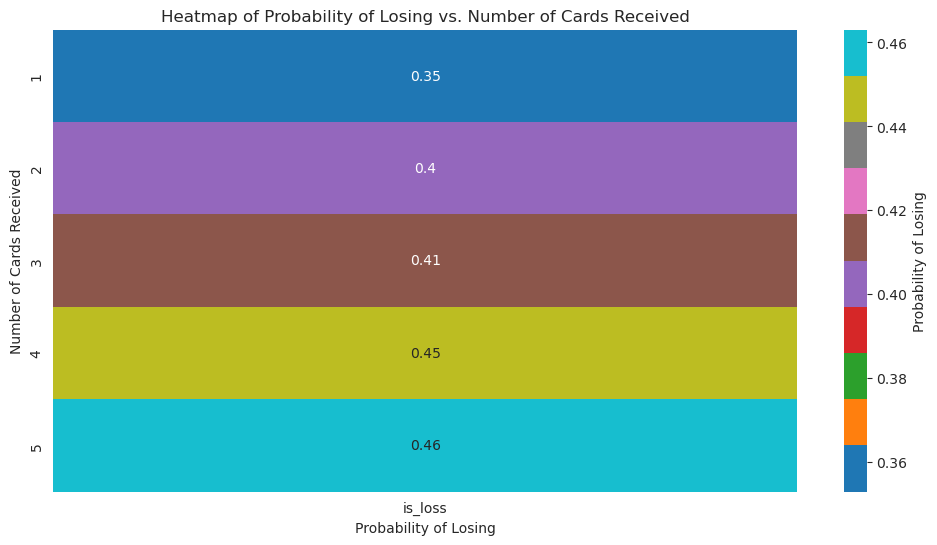

In [217]:
# Filtrare le partite con numero di cartellini maggiore di 0
games_with_cards = (games_df[games_df['cards_received'] > 0]).copy()

games_with_cards.loc[:, 'is_loss'] = games_with_cards['is_win'].apply(
    lambda x: 1 if x == 0 else 0)  # per semplicità aggiungiamo una colonna is_loss

# contiene come index il numero di cartellini e come valore la probabilità di sconfitta
pivot_table = games_with_cards.pivot_table(values='is_loss', index='cards_received', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.color_palette("hls", 8)
sns.heatmap(pivot_table, annot=True, cmap='tab10', cbar_kws={'label': 'Probability of Losing'})
plt.title('Heatmap of Probability of Losing vs. Number of Cards Received')
plt.xlabel('Probability of Losing')
plt.ylabel('Number of Cards Received')
plt.show()


Sembra effettivamente che la probabilità di sconfitta aumenti all'aumentare dell'numero di cartellini

## 2) Probabilità di sconfitta in base al numero di cartellini gialli e rossi

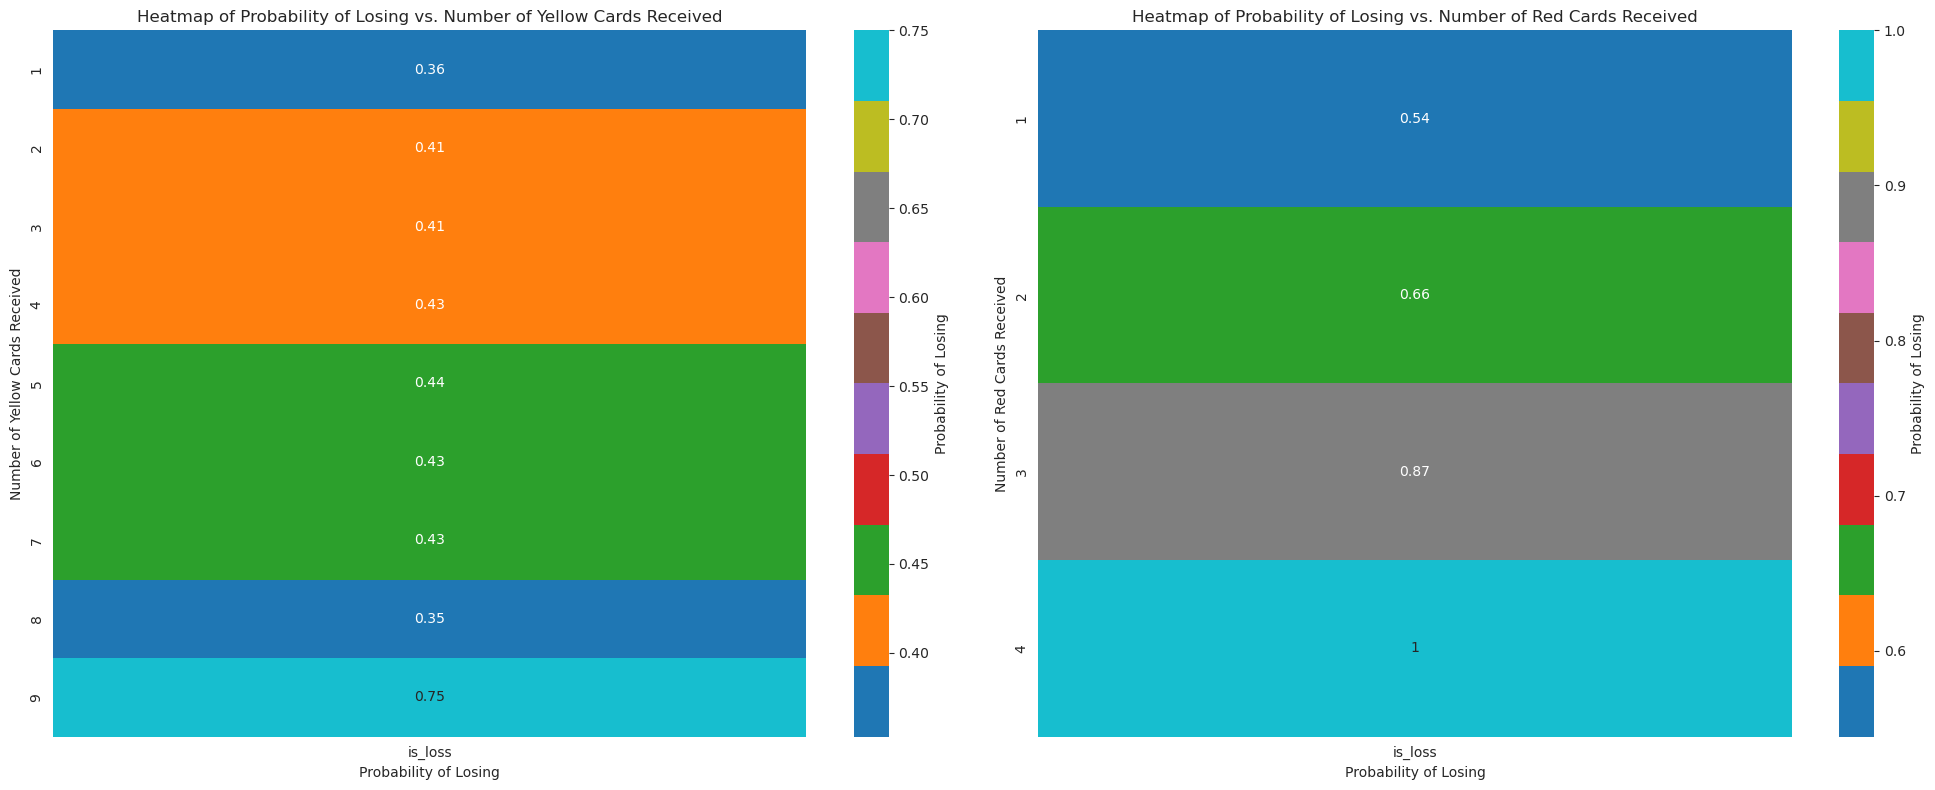

In [218]:
games_with_yellow_cards = (games_df[games_df['cards_received_yellow'] > 0]).copy()

games_with_yellow_cards.loc[:, 'is_loss'] = games_with_yellow_cards['is_win'].apply(
    lambda x: 1 if x == 0 else 0) 

pivot_table_yellow = games_with_yellow_cards.pivot_table(values='is_loss', index='cards_received_yellow', aggfunc='mean')

games_with_red_cards = (games_df[games_df['cards_received_red'] > 0]).copy()

games_with_red_cards.loc[:, 'is_loss'] = games_with_red_cards['is_win'].apply(
    lambda x: 1 if x == 0 else 0)  

pivot_table_red = games_with_red_cards.pivot_table(values='is_loss', index='cards_received_red', aggfunc='mean')

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap per cartellini gialli
sns.heatmap(pivot_table_yellow, annot=True, cmap='tab10', cbar_kws={'label': 'Probability of Losing'}, ax=ax[0])
ax[0].set_title('Heatmap of Probability of Losing vs. Number of Yellow Cards Received')
ax[0].set_xlabel('Probability of Losing')
ax[0].set_ylabel('Number of Yellow Cards Received')

# Heatmap per cartellini rossi
sns.heatmap(pivot_table_red, annot=True, cmap='tab10', cbar_kws={'label': 'Probability of Losing'}, ax=ax[1])
ax[1].set_title('Heatmap of Probability of Losing vs. Number of Red Cards Received')
ax[1].set_xlabel('Probability of Losing')
ax[1].set_ylabel('Number of Red Cards Received')

plt.tight_layout()
plt.show()


Vediamo che anche in questo caso al crescere del numero di cartellini gialli o rossi la probabilità di sconfitta sale di conseguenza.

## Correlazione tra il minutaggio dei goal e il minutaggio dei cartellini
vediamo quanto spesso un goal è segnato in una finestra di tempo vicino al minuto in cui viene ricevuto un cartellino

In [219]:
# Definire una finestra temporale per considerare i goal vicino al minuto del cartellino
time_window = 6  # finestra temporale in minuti

card_events = card_events.rename(columns={'minute': 'minute_card'})
goal_events = goal_events.rename(columns={'minute': 'minute_goal'})

merged_events = pd.merge_asof(card_events.sort_values('minute_card'), 
                              goal_events.sort_values('minute_goal'), 
                              left_on='minute_card', 
                              right_on='minute_goal', 
                              by='game_id', 
                              tolerance=time_window, 
                              direction='nearest')


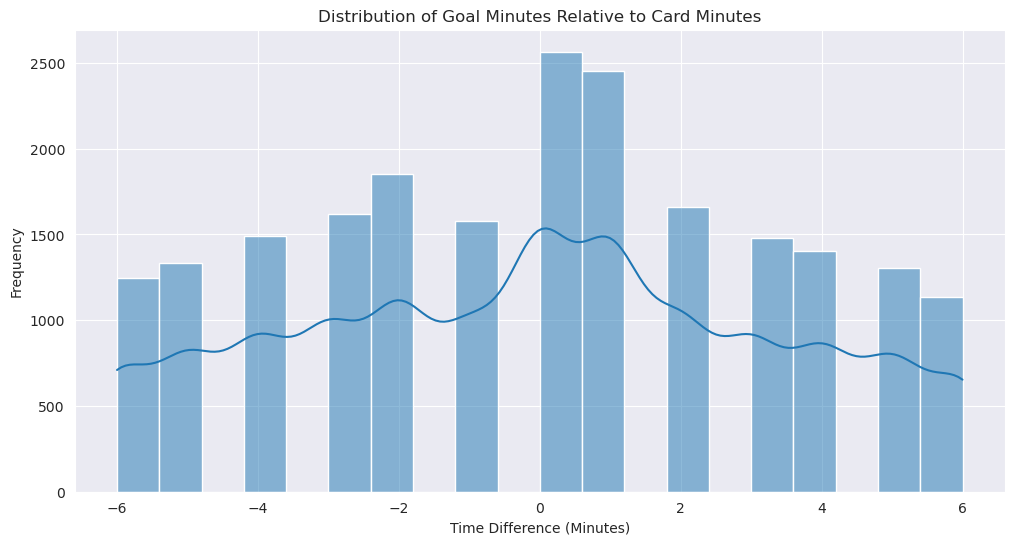

In [220]:
merged_events['time_difference'] = merged_events['minute_goal'] - merged_events['minute_card']

plt.figure(figsize=(12, 6))
sns.histplot(merged_events['time_difference'], bins=20, kde=True)
plt.title('Distribution of Goal Minutes Relative to Card Minutes')
plt.xlabel('Time Difference (Minutes)')
plt.ylabel('Frequency')
plt.show()


Vediamo come dopo lo zero c'è effettivamente un'aumento del numero di goal ricevuti

In [221]:
# Separare i goal che avvengono prima e dopo i cartellini
goals_before_cards = merged_events[merged_events['time_difference'] < 0]
goals_after_cards = merged_events[merged_events['time_difference'] > 0]

# Conteggio dei goal precedenti e successivi
num_goals_before = len(goals_before_cards)
num_goals_after = len(goals_after_cards)

print(f'Numero di goal precedenti ad un cartellino: {num_goals_before}')
print(f'Number of goals successivi ad un cartellino: {num_goals_after} \n')

# Percentuale di goal precedenti e successivi
perc_goals_before = num_goals_before / len(merged_events) * 100
perc_goals_after = num_goals_after / len(merged_events) * 100

print(f'Percentuale di goal precedenti ad un cartellino: {perc_goals_before:.2f}%')
print(f'Percentuale di goal successivi ad un cartellino: {perc_goals_after:.2f}%')


Numero di goal precedenti ad un cartellino: 9115
Number of goals successivi ad un cartellino: 9438 

Percentuale di goal precedenti ad un cartellino: 14.59%
Percentuale di goal successivi ad un cartellino: 15.11%


Vediamo che una parte consistente dei goal è fatta poco tempo dopo l'assegnamento di un cartellino, il che fa pensare che ci sia una correlazione tra i due eventi

In [222]:
# Caricamento dei dati dai file CSV
games_df = pd.read_csv('./data/transformed_games2.csv')


In [223]:
# Calcolare il numero totale di cartellini ricevuti per competizione
total_cards_per_competition = games_df.groupby('competition_id')['cards_received'].sum().reset_index()

# Calcolare il numero totale di partite per competizione
total_games_per_competition = games_df.groupby('competition_id')['game_id'].nunique().reset_index()

# Unire i due dataframes
cards_per_game_per_competition = pd.merge(total_cards_per_competition, total_games_per_competition, on='competition_id')

# Calcolare i cartellini per partita
cards_per_game_per_competition['cards_per_game'] = cards_per_game_per_competition['cards_received'] / cards_per_game_per_competition['game_id']

# Unire con il dataframe delle competizioni per ottenere i nomi delle competizioni
cards_per_game_per_competition = cards_per_game_per_competition.merge(competitions_df[['competition_id', 'name']], on='competition_id')

# Ordinare i risultati per numero di cartellini per partita
cards_per_game_per_competition = cards_per_game_per_competition.sort_values(by='cards_per_game', ascending=False)


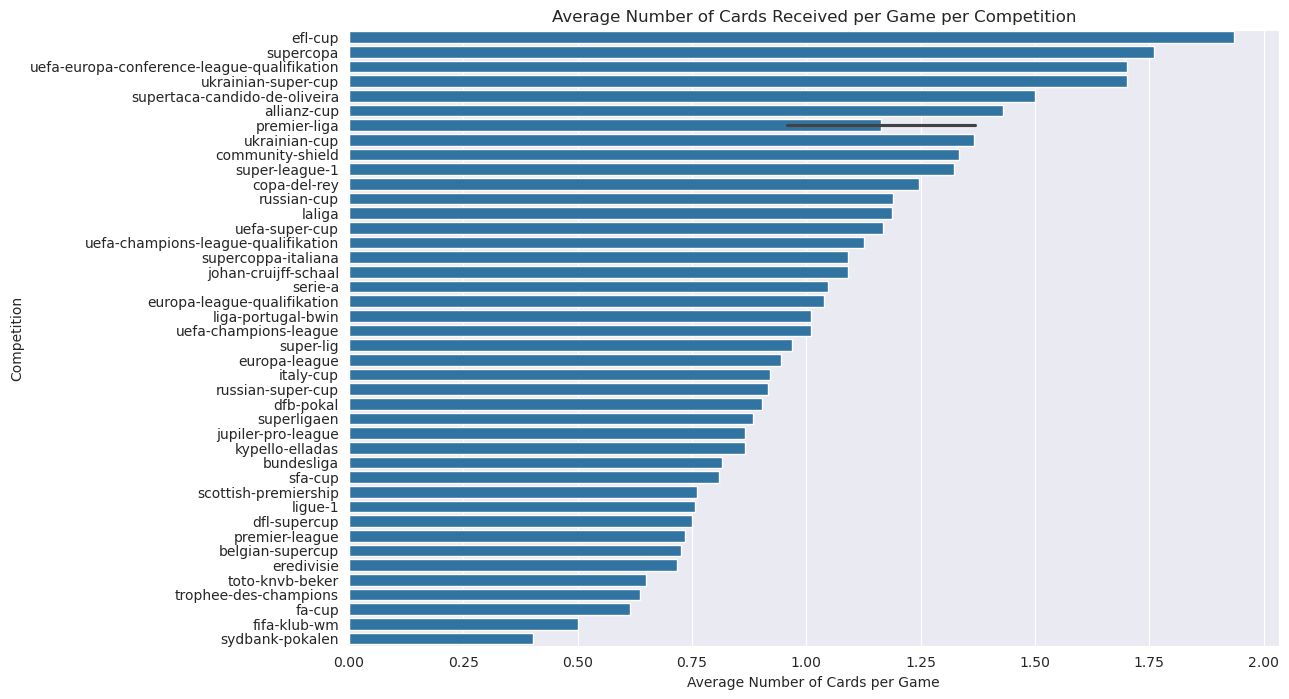

In [224]:
# Grafico a barre per visualizzare il numero di cartellini per partita per competizione
plt.figure(figsize=(12, 8))
sns.barplot(x='cards_per_game', y='name', data=cards_per_game_per_competition)
plt.title('Average Number of Cards Received per Game per Competition')
plt.xlabel('Average Number of Cards per Game')
plt.ylabel('Competition')
plt.show()

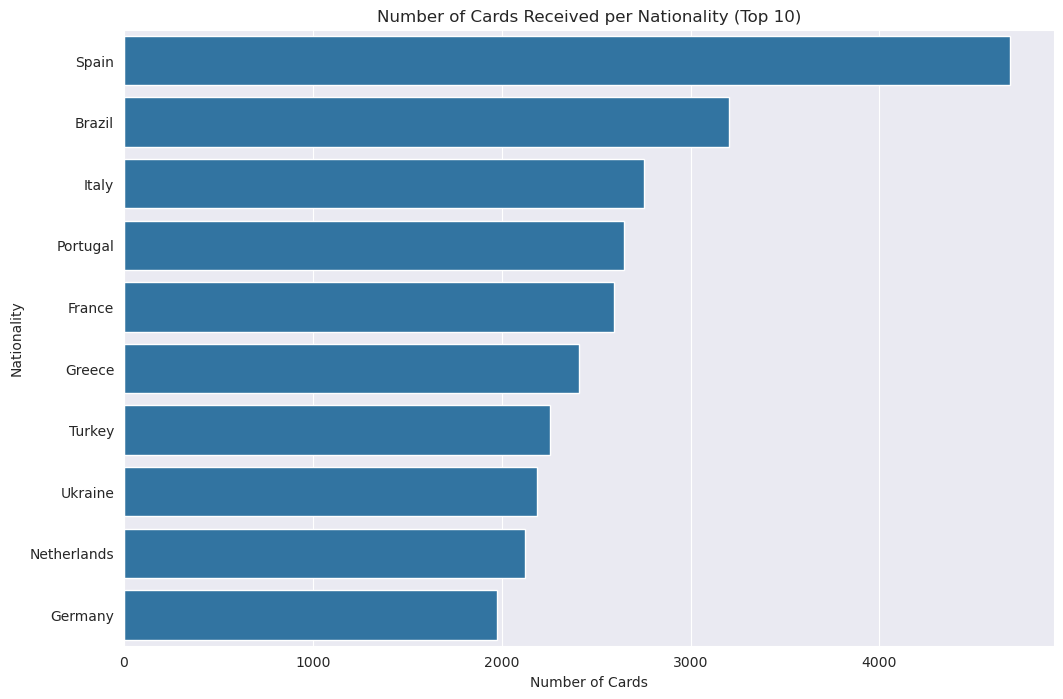

In [225]:
player_cards = card_events.merge(players[['player_id', 'country_of_citizenship']], left_on='player_id', right_on='player_id')

# Contare il numero di cartellini per nazionalità
cards_per_nationality = player_cards['country_of_citizenship'].value_counts().reset_index()
cards_per_nationality.columns = ['country_of_citizenship', 'number_of_cards']

# Grafico a barre per visualizzare il numero di cartellini per nazionalità
plt.figure(figsize=(12, 8))
sns.barplot(x='number_of_cards', y='country_of_citizenship', data=cards_per_nationality.head(10))
plt.title('Number of Cards Received per Nationality (Top 10)')
plt.xlabel('Number of Cards')
plt.ylabel('Nationality')
plt.show()

